In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd

In [175]:
import datetime as dt


ModuleNotFoundError: No module named 'flask'

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [11]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [13]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)

['measurement', 'station']

In [14]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement

In [18]:
# Create our session (link) from Python to the DB
Station = Base.classes.station

In [21]:
inspector = inspect(engine)

In [24]:
m_columns = inspector.get_columns("measurement")
for c in m_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [25]:
s_columns = inspector.get_columns("station")
for c in s_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
session = Session(engine)
# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


('2017-08-23')

In [180]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
dt.date.fromisoformat(last_date)

datetime.date(2017, 8, 23)

In [55]:
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [53]:
year_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).selectable

In [56]:
year_df = pd.read_sql_query(year_data, engine, index_col="measurement_date", parse_dates=["measurement_date"]).sort_index()
year_df

,measurement_prcp
measurement_date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


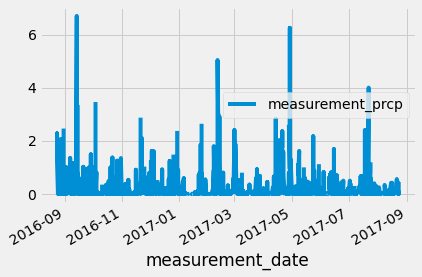

In [59]:
year_df.plot()

In [60]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_df.describe()

,measurement_prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [97]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(f"There are {station_count} stations in this dataset")

9

In [162]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count()).\
    group_by(Measurement.station).\
    order_by(func.count().desc()).all()

busiest_id = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count().desc()).first()[0]
busiest_id



'USC00519281'

In [181]:
session.query(Measurement.date, func.min(Measurement.tobs)).\
filter(Measurement.date > year_ago).all()

[('2017-04-30', 58.0)]

In [169]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

bsmall = session.query(Measurement.station, func.min(Measurement.tobs)).\
    group_by(Measurement.station).\
    filter(Measurement.station == busiest_id).all()[0][1]

bbig = session.query(Measurement.station, func.max(Measurement.tobs)).\
    group_by(Measurement.station).\
    filter(Measurement.station == busiest_id).all()[0][1]

bmean = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    group_by(Measurement.station).\
    filter(Measurement.station == busiest_id).all()[0][1]


print(f"The smallest temperature recorded was {bsmall}")
print(f"The highest temperature recorded was {bbig}")
print(f"The average temperature recorded was {bmean}")


The smallest temperature recorded was 54.0
The highest temperature recorded was 85.0
The average temperature recorded was 71.66378066378067


,id,station,date,prcp,tobs
13293,13294,USC00519281,2013-01-16,0.02,54.0


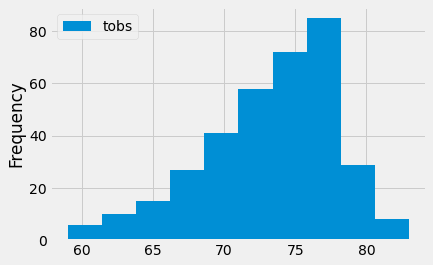

In [174]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_df = pd.read_sql_query(session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > year_ago).\
    filter(Measurement.station == busiest_id).statement,
                            engine,
                            index_col="date",
                            parse_dates=["date"])
tobs_df.plot(kind="hist")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
